In [7]:
import json
import os

import numpy as np
import librosa
import pandas as pd
from scipy.io import wavfile
import matplotlib.pyplot as plt
import webrtcvad
from imblearn.over_sampling import ADASYN, SMOTE
from sklearn.preprocessing import LabelEncoder

folders = ['MinhQuang', 'Unknown', 'Noise']
SAMPLE_RATE = 16000


In [8]:
def envelope(y, rate, threshold):
    mask = []
    y = pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/10), min_periods=1, center=True).mean()
    for mean in y_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask

def process_audio_with_voice_detection(file_path, output_dir, sample_rate=16000):
    # check ouput folder
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    # Đọc tệp âm thanh
    data, sr = librosa.load(file_path, sr=sample_rate)


    file_name = file_path.split('/')[-1]
    
    vad = webrtcvad.Vad(3)
    
    # Chia tệp âm thanh thành các phần có chứa giọng nói
    frames = librosa.effects.split(data, top_db=20)
    voiced_segments = []
    for start, end in frames:
        segment = data[start:end]
        if vad.is_speech(segment.tobytes(), sample_rate, length=len(segment)):
            voiced_segments.append(segment)
    
    # Chia các đoạn giọng nói thành các chunks 1 giây
    chunk_size = int(1 * sample_rate) # 1s
    chunks = []
    for segment in voiced_segments:
        for i in range(0, len(segment), chunk_size):
            chunk = segment[i:i + chunk_size]
            if len(chunk) == chunk_size:
                chunks.append(chunk)
    
    # Lưu các đoạn âm thanh có giọng nói vào thư mục đầu ra
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    if(len(voiced_segments) == 0):
        print(f"No voice detected in {file_path}")
        return
    if(len(voiced_segments) > 1):
        print(f"Multiple voices detected in {file_path}, please check by hand!")
        return
    for i, segment in enumerate(voiced_segments):
        save_file(output_dir, f"{file_name}.wav", segment)


def save_resampled_file(folder, file, data):
    if not os.path.exists(f'data_resampled/{folder}'):
        os.makedirs(f'data_resampled/{folder}')
    
    # check 1s audio
    if len(data) != SAMPLE_RATE:
        if len(data) < SAMPLE_RATE :
            data = np.pad(data, (0, max(0, SAMPLE_RATE - len(data))), 'constant')
        elif len(data) > SAMPLE_RATE and len(data) < 2*SAMPLE_RATE:
            data = data[:SAMPLE_RATE]
        else:
            print(f"Audio {file} is more than 2s long: {len(data)}, check by hand!")
    # save file in wav
    file_name = f'data_resampled/{folder}/{file}'

    wavfile.write(file_name, SAMPLE_RATE, data)

def save_file(folder, file, data):
    if not os.path.exists(f'data/{folder}'):
        os.makedirs(f'data/{folder}')
    
    # check 1s audio
    if len(data) != SAMPLE_RATE:
        if len(data) < SAMPLE_RATE :
            data = np.pad(data, (0, max(0, SAMPLE_RATE - len(data))), 'constant')
        elif len(data) > SAMPLE_RATE and len(data) < 2*SAMPLE_RATE:
            data = data[:SAMPLE_RATE]
        else:
            print(f"Audio {file} is more than 2s long: {len(data)}, check by hand!")
    # save file in wav
    file_name = f'data/{folder}/{file}'

    wavfile.write(file_name, SAMPLE_RATE, data)

In [9]:
# tạo dữ liệu cho mô hình

def add_noise(audio, noise_factor=0.02):
    noise = np.random.randn(len(audio))
    augmented_audio = audio + noise_factor * noise
    augmented_audio = np.clip(augmented_audio, -1, 1, augmented_audio).astype(np.float32)
    return augmented_audio


# thay đổi tốc độ
def speed_change(audio, speed_factor=1.2):
    augmented_audio = librosa.effects.time_stretch(audio, rate=speed_factor)
    return augmented_audio

def add_background_noise(audio):
    # add noise in raw_data/Noise folder
    noise = np.random.choice(os.listdir('raw_data/Noise'))
    noise, _ = librosa.load(f'raw_data/Noise/{noise}', sr=16000)
    if len(noise) < len(audio):
        noise = np.tile(noise, len(audio) // len(noise) + 1)
    noise = noise[:len(audio)]

    # reduce noise volume
    noise_factor = np.random.uniform(0.0001, 0.002)
    noise = noise * noise_factor
    
    augmented_audio = audio + noise
    return augmented_audio

def add_noise_to_audio(audio):
    noise_factor = np.random.uniform(0.0001, 0.002)
    augmented_audio = add_noise(audio, noise_factor)
    return augmented_audio



def change_volume(audio):
    volume_factor = np.random.uniform(0.5, 1.5)
    augmented_audio = audio * volume_factor
    return augmented_audio


In [10]:
def show_distribute_data(root='data'):
    time_lengths = [0, 0, 0]
    i = 0
    count_not_1 = 0
    for folder in folders:
        for file in os.listdir(f'{root}/{folder}'):
            audio, _ = librosa.load(f'{root}/{folder}/{file}', sr=16000)
            time_lengths[i] += len(audio) / 16000
            if len(audio) / 16000 != 1:
                count_not_1 += 1
                # print(file)
        i += 1
    # draw pie chart
    plt.pie(time_lengths, labels=folders, autopct='%1.1f%%')

    plt.show()
    print(time_lengths)

            

Error: 20127295_Minh Quang_rec1.wav is not 1s, it is 1.5s
Error: 20127295_Minh Quang_rec10.wav is not 1s, it is 1.5s
Error: 20127295_Minh Quang_rec2.wav is not 1s, it is 1.56s
Error: 20127295_Minh Quang_rec3.wav is not 1s, it is 1.68s
Error: 20127295_Minh Quang_rec4.wav is not 1s, it is 1.5s
Error: 20127295_Minh Quang_rec5.wav is not 1s, it is 1.56s
Error: 20127295_Minh Quang_rec6.wav is not 1s, it is 1.68s
Error: 20127295_Minh Quang_rec7.wav is not 1s, it is 1.5s
Error: 20127295_Minh Quang_rec8.wav is not 1s, it is 1.56s
Error: 20127295_Minh Quang_rec9.wav is not 1s, it is 1.68s
Error: 21127345_CamNhung_rec8.wav is not 1s, it is 1.0000625s
Raw data: 


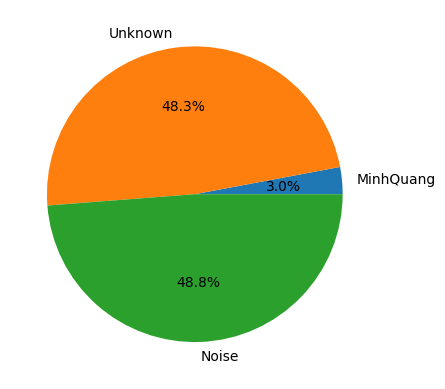

[93.0, 1520.0, 1536.0]
After augumented: 


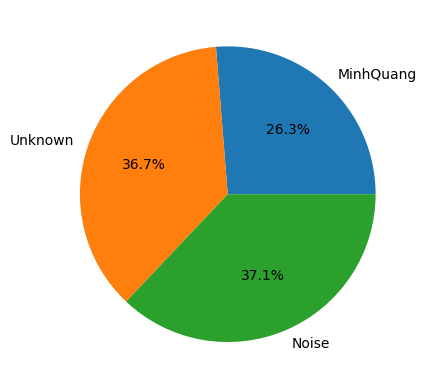

[1089.0, 1520.0, 1536.0]
Total resampled data:  4608
Resampled MinhQuang:  1536
Resampled Unknown:  1536
Resampled Noise:  1536
After resampled: 


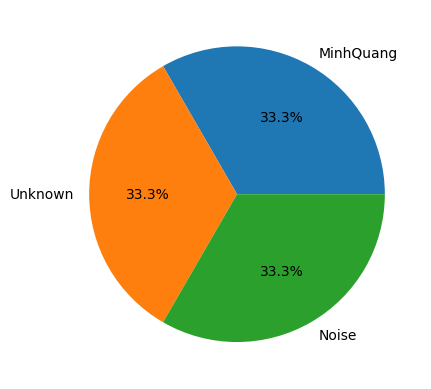

[1536.0, 1536.0, 1536.0]


In [11]:
def process_files():

    data = []
    labels = []
    #copy file
    for folder in folders:
        if not os.path.exists(f'data/{folder}'):
            os.makedirs(f'data/{folder}')
        for file in os.listdir(f'raw_data/{folder}'):
            audio, sr = librosa.load(f'raw_data/{folder}/{file}', sr=16000)
            save_file(folder, file, audio)
            if(sr != 16000):
                print(f'Error: {file} is not 16k')
                continue
            if(len(audio) != 16000):
                print(f'Error: {file} is not 1s, it is {len(audio) / 16000}s')
                # process_audio_with_voice_detection(f'raw_data/{folder}/{file}', f'data/reprocess/{folder}')
                continue

            data.append(audio)
            labels.append(folder)   
            
                

    # show distribution data when not augumented
    print("Raw data: ")
    show_distribute_data()

    for file in os.listdir(f'raw_data/MinhQuang'):
        audio, sr = librosa.load(f'raw_data/MinhQuang/{file}', sr=16000)
        if(sr != 16000):
            continue
        if(len(audio) != 16000):
            continue

        for i in range(3):
            random_name = str(i)
            # create more data
            # add noise
            augmented_audio = add_noise_to_audio(audio)
            save_file('MinhQuang', "noise_" + random_name + file, augmented_audio)
            data.append(augmented_audio)
            labels.append('MinhQuang')

            # add background noise
            augmented_audio = add_background_noise(audio)
            save_file('MinhQuang', "bg_" + random_name + file, augmented_audio)
            data.append(augmented_audio)
            labels.append('MinhQuang')

            # change speed
            speed_factor = np.random.uniform(0.8, 1.2)
            augmented_audio = speed_change(audio, speed_factor)
            # save file in wav with 1s length
            if(len(augmented_audio) < 16000):
                augmented_audio = np.pad(augmented_audio, (0, 16000 - len(augmented_audio)), 'constant')
            else:
                augmented_audio = augmented_audio[:16000]
            data.append(augmented_audio)
            labels.append('MinhQuang')
            save_file('MinhQuang', "speed_" + random_name + file, augmented_audio)


            # change volume
            augmented_audio = change_volume(audio)
            save_file('MinhQuang', "volume_" + random_name + file, augmented_audio)
            data.append(augmented_audio)
            labels.append('MinhQuang')
    print("After augumented: ")
    show_distribute_data()


    # over sampling
    data = np.array(data)
    data = data.reshape(len(data), -1) 

    # Encode labels
    le = LabelEncoder()
    labels_encoded = le.fit_transform(labels)

    # Over-sampling with SMOTE
    smote = SMOTE(random_state=42)
    # adasyn = SMOTE(sampling_strategy='minority', random_state=42)
    data_resampled, labels_resampled = smote.fit_resample(data, labels_encoded)


    resampled_folder = 'data_resampled'
    if not os.path.exists(resampled_folder):
        os.makedirs(resampled_folder)

    count_resempled_mq = 0
    count_resempled_unknown = 0
    count_resempled_noise = 0

    resampled_folder = 'data_resampled'

    for i, (audio, label) in enumerate(zip(data_resampled, labels_resampled)):
        audio = audio.reshape(-1)
        folder = le.inverse_transform([label])[0]
        save_resampled_file(folder, f"resampled_{i}.wav", audio)
        
        if folder == 'MinhQuang':
            count_resempled_mq += 1
        elif folder == 'Unknown':
            count_resempled_unknown += 1
        else:
            count_resempled_noise += 1
    
    print("Total resampled data: ", len(data_resampled))
    print("Resampled MinhQuang: ", count_resempled_mq)
    print("Resampled Unknown: ", count_resempled_unknown)
    print("Resampled Noise: ", count_resempled_noise)
    print("After resampled: ")
    show_distribute_data(resampled_folder)






process_files()
# show_distribute_data()
            
